In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

In [2]:
print(tf.__version__)

2.8.0


In [3]:
!wget "https://github.com/rondweb/PythonScriptsBigData/raw/main/data/dataset/soya_pests.zip"
!unzip soya_pests.zip

--2022-05-18 16:16:54--  https://github.com/rondweb/PythonScriptsBigData/raw/main/data/dataset/soya_pests.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rondweb/PythonScriptsBigData/main/data/dataset/soya_pests.zip [following]
--2022-05-18 16:16:54--  https://raw.githubusercontent.com/rondweb/PythonScriptsBigData/main/data/dataset/soya_pests.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6174738 (5.9M) [application/zip]
Saving to: ‘soya_pests.zip’

soya_pests.zip      100%[===================>]   5.89M  --.-KB/s    in 0.05s   

2022-05-18 16:16:55 (113 MB/s) - ‘soya_pests.zip’ saved [6

In [ ]:
!mv plagues.zip /content/plagues
!unzip /content/plagues/plagues.zip

In [6]:
data_dir = "soya_pests/"
batch_size = 1
img_height = 200
img_width = 167

train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/soya_pests/train",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10 files belonging to 2 classes.
Using 8 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/soya_pests/test",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8 files belonging to 2 classes.
Using 1 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['anticarsia_gemmatalis', 'elasmopalpus_lignosellus']


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(1, 200, 167, 3)
(1,)


In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99702257


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [21]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [28]:
training_hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=9 
)

Epoch 1/9
8/8 [==============================] - 0s 52ms/step - loss: 1.1161e-05 - accuracy: 1.0000 - val_loss: 1.1789e-04 - val_accuracy: 1.0000
Epoch 2/9
8/8 [==============================] - 0s 54ms/step - loss: 9.8495e-06 - accuracy: 1.0000 - val_loss: 1.2075e-04 - val_accuracy: 1.0000
Epoch 3/9
8/8 [==============================] - 0s 55ms/step - loss: 8.5680e-06 - accuracy: 1.0000 - val_loss: 1.3660e-04 - val_accuracy: 1.0000
Epoch 4/9
8/8 [==============================] - 0s 54ms/step - loss: 7.5250e-06 - accuracy: 1.0000 - val_loss: 1.5901e-04 - val_accuracy: 1.0000
Epoch 5/9
8/8 [==============================] - 0s 52ms/step - loss: 6.7203e-06 - accuracy: 1.0000 - val_loss: 1.8440e-04 - val_accuracy: 1.0000
Epoch 6/9
8/8 [==============================] - 0s 54ms/step - loss: 6.1243e-06 - accuracy: 1.0000 - val_loss: 2.1086e-04 - val_accuracy: 1.0000
Epoch 7/9
8/8 [==============================] - 0s 49ms/step - loss: 5.6773e-06 - accuracy: 1.0000 - val_loss: 2.3684e-04 -

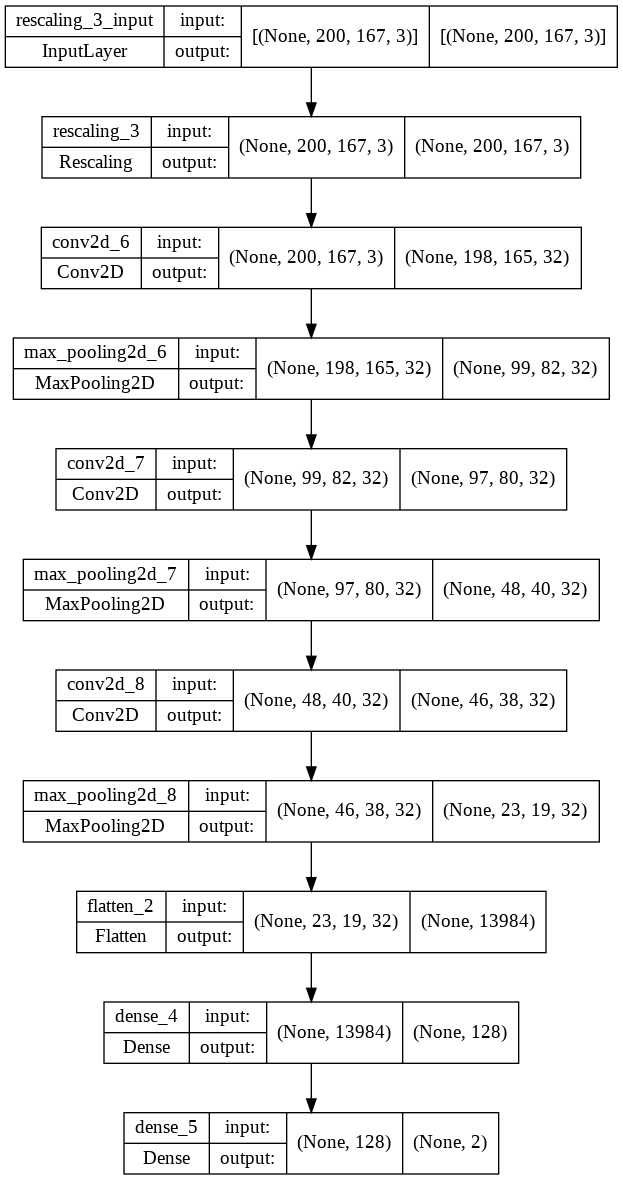

In [29]:
keras.utils.plot_model(model, 'model_image_classification_shapes.png', show_shapes=True)

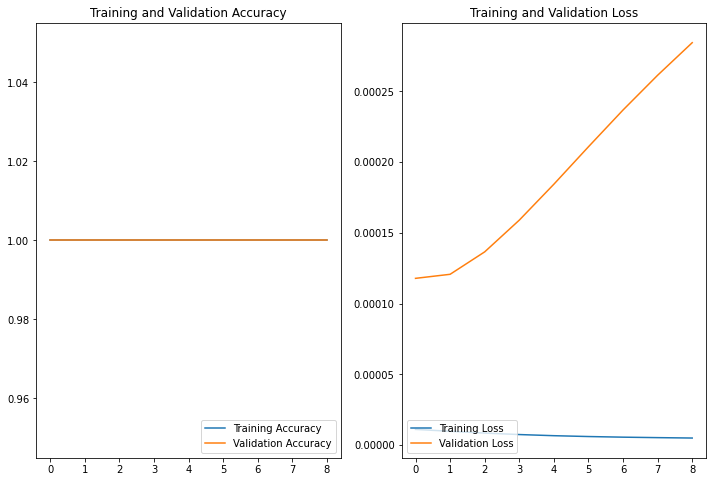

In [31]:
acc = training_hist.history['accuracy']
val_acc = training_hist.history['val_accuracy']

loss = training_hist.history['loss']
val_loss = training_hist.history['val_loss']

epochs_range = range(9)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend(loc='lower left')

plt.title('Training and Validation Loss')
plt.show()

In [32]:
model.save('/content/model_prev_plagues')

INFO:tensorflow:Assets written to: /content/model_prev_plagues/assets


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix


In [37]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory='/content/soya_pests/test/',
                                                           shuffle=True,
                                                           target_size=(img_height, img_width))

Found 8 images belonging to 2 classes.


In [48]:
predictions = model.predict(test_data_gen)
predictions

array([[-1.0726814 ,  0.93276703],
       [-1.0438272 ,  0.9093427 ],
       [-1.0712442 ,  0.9307269 ],
       [-1.0381796 ,  0.90481645],
       [-1.062793  ,  0.9224119 ],
       [-1.0680411 ,  0.9278548 ],
       [-1.0415282 ,  0.90550643],
       [-1.0744097 ,  0.93414146]], dtype=float32)

In [49]:
num_of_test_samples = 16
batch_size = 1
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_data_gen, num_of_test_samples)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_data_gen.classes, y_pred))
print('Classification Report')
target_names = ['anticarsia_gemmatalis','elasmopalpus_lignosellus']
print(classification_report(test_data_gen.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


Confusion Matrix
[[0 4]
 [0 4]]
Classification Report
                          precision    recall  f1-score   support

   anticarsia_gemmatalis       0.00      0.00      0.00         4
elasmopalpus_lignosellus       0.50      1.00      0.67         4

                accuracy                           0.50         8
               macro avg       0.25      0.50      0.33         8
            weighted avg       0.25      0.50      0.33         8



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
